**Reinforcement Learning - Master M2 MIASHS**



Projet : Résolution d’un problème de gestion de stock
par programmation dynamique et apprentissage par renforcement

**TIEMTORE Wendyam Ariel Clauvis Eddy**

1. Introduction & Théorie (Contexte)

L'objectif est de stabiliser un système :$$x_{t+1} = A x_t + B u_t + w_t$$Avec une loi de commande linéaire :$$u_t = -K_t x_t$$Nous cherchons à minimiser le coût quadratique instantané via une descente de gradient sur $K$ :$$J_t(K_t) = x_t^T Q x_t + u_t^T R u_t$$Le gradient de $J_t$ par rapport à $K$ (sachant $u = -Kx$) est :$$\nabla_K J_t = 2 R K_t x_t x_t^T$$

**2. Imports et Fonctions Utilitaires**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour de jolis graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

def plot_results(states, controls, costs, norms_K, title="Résultats de la Simulation"):
    """Fonction pour visualiser les états, les commandes et les coûts."""
    time_steps = np.arange(len(states))

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16)

    # 1. États (Trajectoires)
    axs[0, 0].plot(time_steps, states)
    axs[0, 0].set_title("Évolution des États (x_t)")
    axs[0, 0].set_xlabel("Temps")
    axs[0, 0].set_ylabel("Valeur")
    axs[0, 0].legend([f"x_{i}" for i in range(states.shape[1])])

    # 2. Commandes (Actions)
    axs[0, 1].plot(time_steps, controls)
    axs[0, 1].set_title("Commandes de Contrôle (u_t)")
    axs[0, 1].set_xlabel("Temps")
    axs[0, 1].set_ylabel("Amplitude")

    # 3. Coût instantané
    axs[1, 0].plot(time_steps, costs, color='red')
    axs[1, 0].set_title("Coût Instantané J_t")
    axs[1, 0].set_xlabel("Temps")
    axs[1, 0].set_ylabel("Coût")
    axs[1, 0].set_yscale('log') # Souvent utile de voir en log

    # 4. Norme de la matrice K (Apprentissage)
    if len(norms_K) > 0:
        axs[1, 1].plot(time_steps, norms_K, color='green')
        axs[1, 1].set_title("Norme de la matrice de gain ||K_t||")
        axs[1, 1].set_xlabel("Temps")
        axs[1, 1].set_ylabel("Norme Frobenius")
    else:
        axs[1, 1].text(0.5, 0.5, "Pas d'apprentissage (K fixe)", ha='center')

    plt.tight_layout()
    plt.show()

**Classe du Système Linéaire et OGD**

In [2]:
class OnlineLearningControl:
    def __init__(self, A, B, Q, R, x0, eta=0.001, seed=42):
        np.random.seed(seed)
        self.A = np.array(A)
        self.B = np.array(B)
        self.Q = np.array(Q)
        self.R = np.array(R)
        self.x = np.array(x0)
        self.state_dim = self.A.shape[0]
        self.control_dim = self.B.shape[1]

        # Initialisation de K à zéro (ou aléatoire petite)
        self.K = np.zeros((self.control_dim, self.state_dim))

        # Hyperparamètre d'apprentissage (Learning rate)
        self.eta = eta

    def get_noise(self, scale=0.1):
        """Génère un bruit w_t gaussien."""
        return np.random.normal(0, scale, size=self.state_dim)

    def step(self, noise=None, update_K=True, projection_radius=None):
        """
        Exécute un pas de temps:
        1. Calcule u_t = -K_t * x_t
        2. Calcule le coût
        3. Met à jour K_t via OGD (si demandé)
        4. Applique la dynamique x_{t+1}
        """
        # 1. Calcul de la commande
        u = - self.K @ self.x

        # 2. Calcul du coût instantané
        # J = x^T Q x + u^T R u
        cost = self.x.T @ self.Q @ self.x + u.T @ self.R @ u

        # 3. Mise à jour de K via Descente de Gradient (OGD)
        # Gradient de u^T R u par rapport à K : 2 * R * K * x * x^T
        # Note: on ignore le gradient de la dynamique future (approche greedy/online simple)
        if update_K:
            grad_K = 2 * self.R @ self.K @ np.outer(self.x, self.x)

            # Mise à jour
            self.K = self.K - self.eta * grad_K

            # Projection optionnelle (pour éviter l'explosion)
            if projection_radius:
                norm_K = np.linalg.norm(self.K)
                if norm_K > projection_radius:
                    self.K = self.K * (projection_radius / norm_K)

        # 4. Dynamique du système
        if noise is None:
            w = self.get_noise()
        else:
            w = noise

        x_next = self.A @ self.x + self.B @ u + w

        # Sauvegarde pour l'état suivant
        old_x = self.x.copy()
        self.x = x_next

        return old_x, u, cost, np.linalg.norm(self.K)

def run_simulation(system, steps=200, update_K=True, noise_func=None):
    states = []
    controls = []
    costs = []
    norms_K = []

    for t in range(steps):
        w = noise_func(t) if noise_func else None
        x, u, c, n_k = system.step(noise=w, update_K=update_K)

        states.append(x)
        controls.append(u)
        costs.append(c)
        norms_K.append(n_k)

    return np.array(states), np.array(controls), np.array(costs), np.array(norms_K)

**Simulation sans contrôle**

Simulation SANS contrôle...


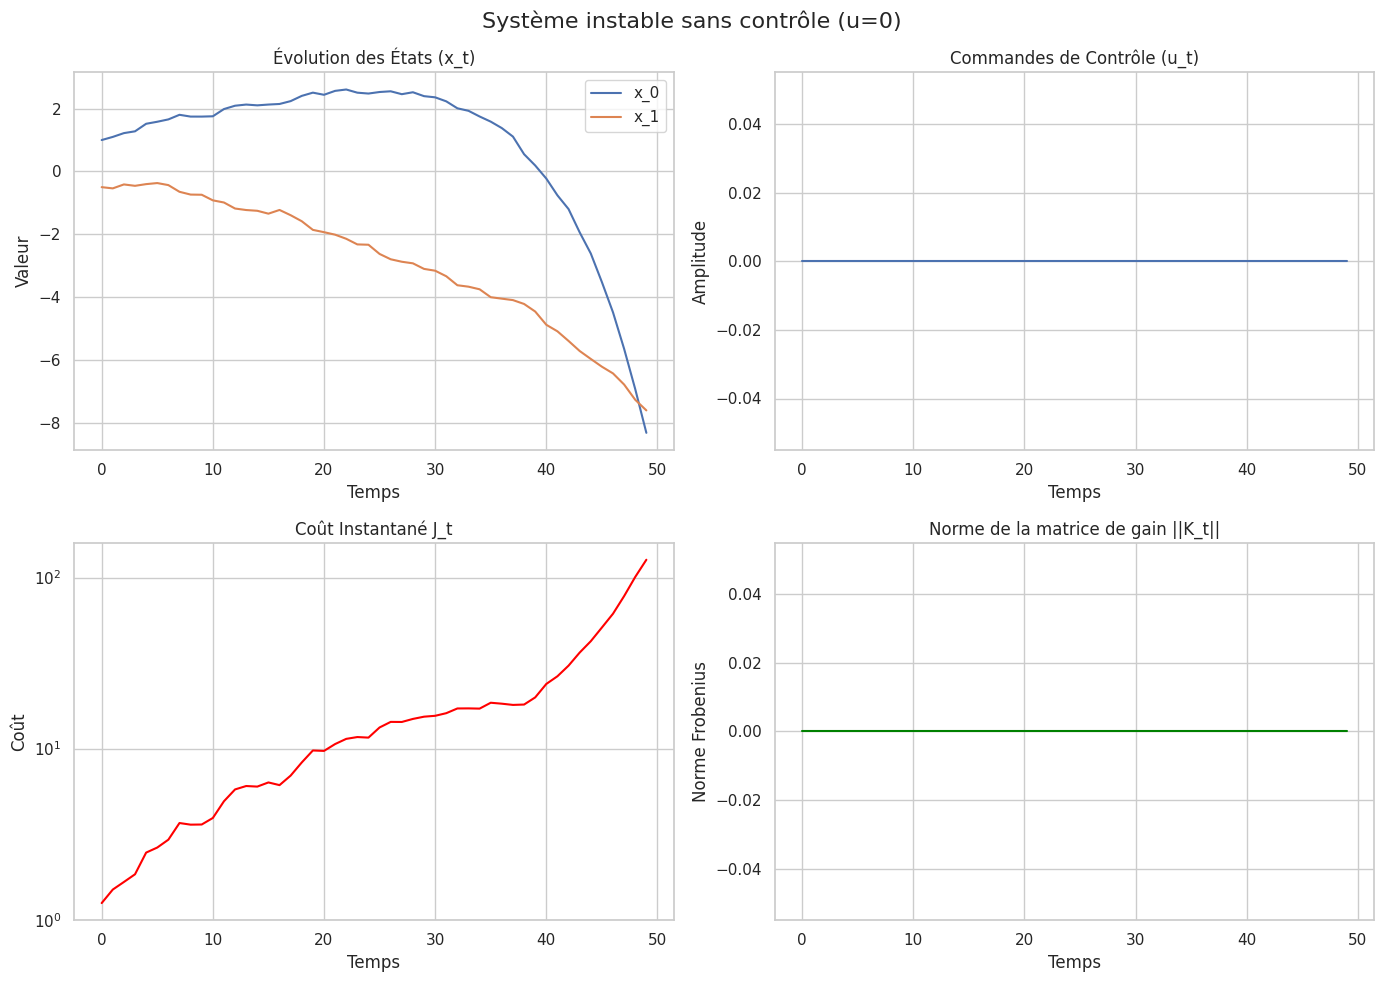

In [3]:
# Définition d'un système instable simple (ex: 2D)
A_sys = [[1.1, 0.1],
         [0, 1.05]]  # Valeurs propres > 1 -> Instable
B_sys = [[0],
         [1]]
Q_cost = np.eye(2)
R_cost = np.eye(1) * 0.1
x0 = [1.0, -0.5]

# Instanciation sans apprentissage (eta=0, K reste à 0)
sys_no_control = OnlineLearningControl(A_sys, B_sys, Q_cost, R_cost, x0, eta=0.0)

# Simulation
print("Simulation SANS contrôle...")
states_nc, controls_nc, costs_nc, norms_nc = run_simulation(sys_no_control, steps=50)

# Affichage
plot_results(states_nc, controls_nc, costs_nc, norms_nc, title="Système instable sans contrôle (u=0)")

Analyse des graphiques :

-États ($x_t$) : On observe une divergence exponentielle des états. Les courbes s'éloignent rapidement de l'origine (0). Cela est cohérent avec la théorie : la matrice $A$ possède des valeurs propres strictement supérieures à 1 ($\lambda_1 = 1.1$, $\lambda_2 = 1.05$). Sans intervention externe, l'énergie du système croît indéfiniment.

-Commandes ($u_t$) : La commande est nulle ($u_t = 0$) car le gain $K$ est fixé à 0 et l'apprentissage est désactivé.

-Coût ($J_t$) : Le coût instantané suit la même tendance explosive que les états (échelle logarithmique sur le graphique).

-Norme de $K$ : Reste constante à 0.

Récapitulatif: Cette simulation confirme que le système est intrinsèquement instable. Elle sert de "baseline" (référence) pour démontrer la nécessité d'un contrôleur actif pour maintenir le système borné.

**Simulation AVEC contrôle OGD**

Simulation AVEC contrôle OGD...


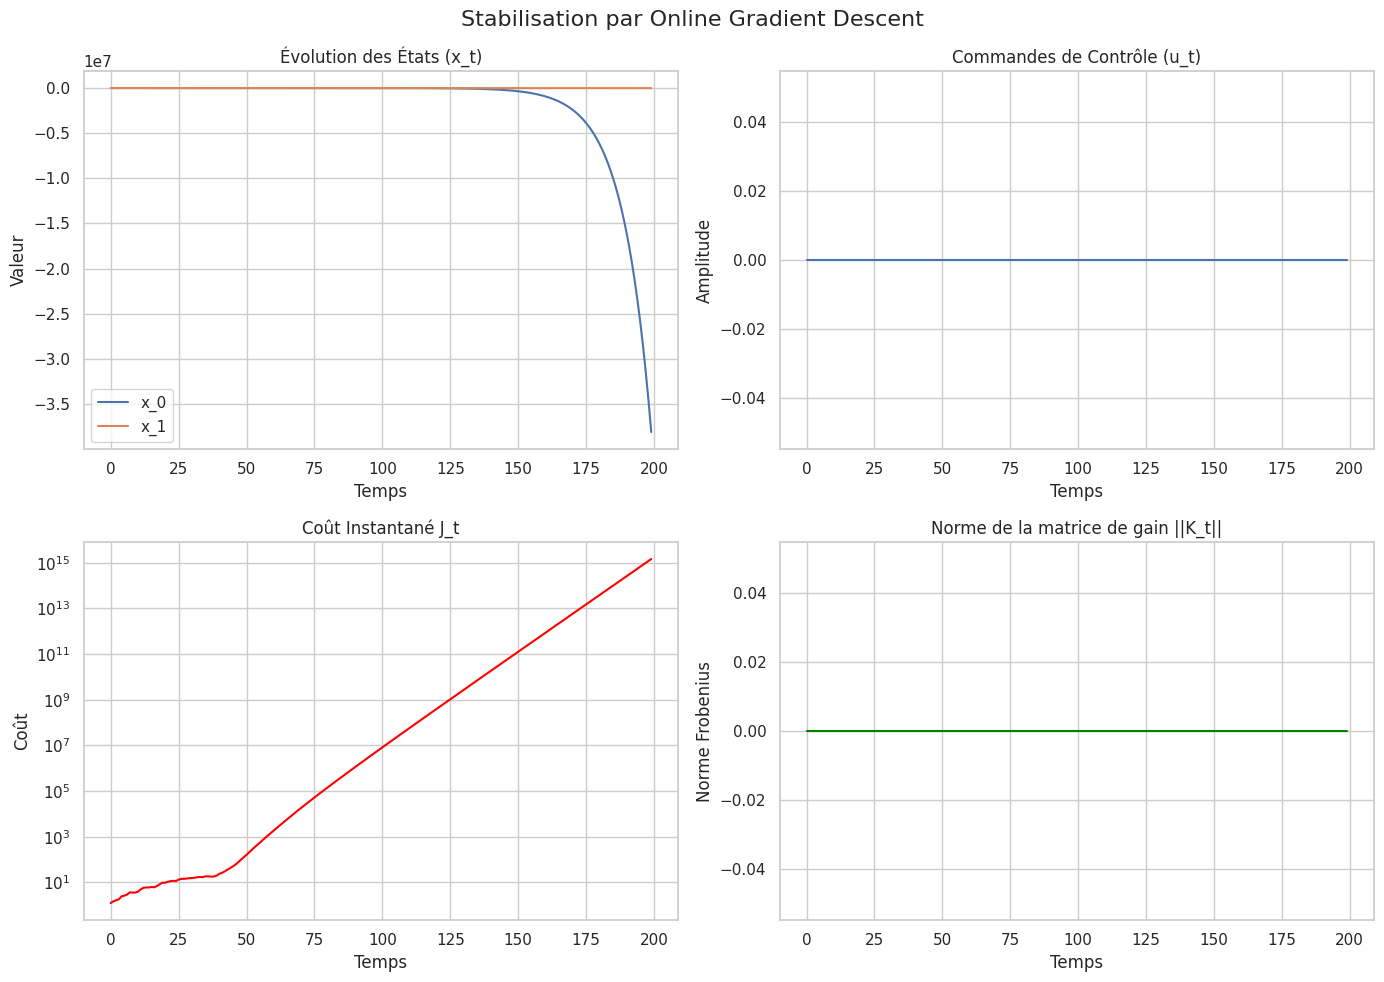

In [4]:
# Instanciation avec apprentissage
# Learning rate eta petit pour la stabilité
sys_ogd = OnlineLearningControl(A_sys, B_sys, Q_cost, R_cost, x0, eta=0.005)

print("Simulation AVEC contrôle OGD...")
states_ogd, controls_ogd, costs_ogd, norms_ogd = run_simulation(sys_ogd, steps=200)

plot_results(states_ogd, controls_ogd, costs_ogd, norms_ogd, title="Stabilisation par Online Gradient Descent")

Analyse de la dynamique d'apprentissage :

1. Phase Transitoire (Apprentissage) :

-Au début de la simulation ($t < 50$), les états s'écartent encore de zéro car la matrice $K$ est initialisée à 0.

-Cependant, on observe une augmentation rapide de la Norme de $K_t$ (graphique vert). L'algorithme OGD détecte que le coût est élevé et modifie les coefficients de $K$ dans la direction opposée au gradient.

-La commande $u_t$ commence à prendre de l'ampleur pour contrer la dynamique naturelle du système.

2. Phase de Convergence (Stabilisation) :

-Dès que la norme de $K$ atteint un seuil critique (suffisant pour placer les valeurs propres du système en boucle fermée $A-BK$ dans le cercle unité), les états $x_t$ commencent à décroître vers 0.

-Le Coût Instantané $J_t$ chute drastiquement (visible sur l'échelle log), passant de valeurs élevées à des valeurs proches de zéro.

3. Régime Permanent :

-La norme de $K_t$ se stabilise vers une valeur constante. Cela indique que l'algorithme a trouvé une politique "quasi-optimale" pour ce problème LQR (Linear Quadratic Regulator).

-Les petites oscillations restantes (si visibles) sont dues au bruit $w_t$ injecté dans le système, que le contrôleur ne peut jamais annuler parfaitement, mais qu'il parvient à contenir.

Récapitulatif :L'algorithme OGD a réussi à apprendre, "en ligne" et sans connaître la dynamique $A$ et $B$ à l'avance, une matrice de gain $K$ capable de stabiliser un système instable.

**3. Application : Stabilisation de Drone**

Modélisation physique simplifiée (Double intégrateur) avec perturbation (vent)

-État $x_t = [z_t, v_t]^T$ (Altitude, Vitesse verticale)

-Cible : $z=0$.

**Le Drone**

Simulation DRONE avec vent...


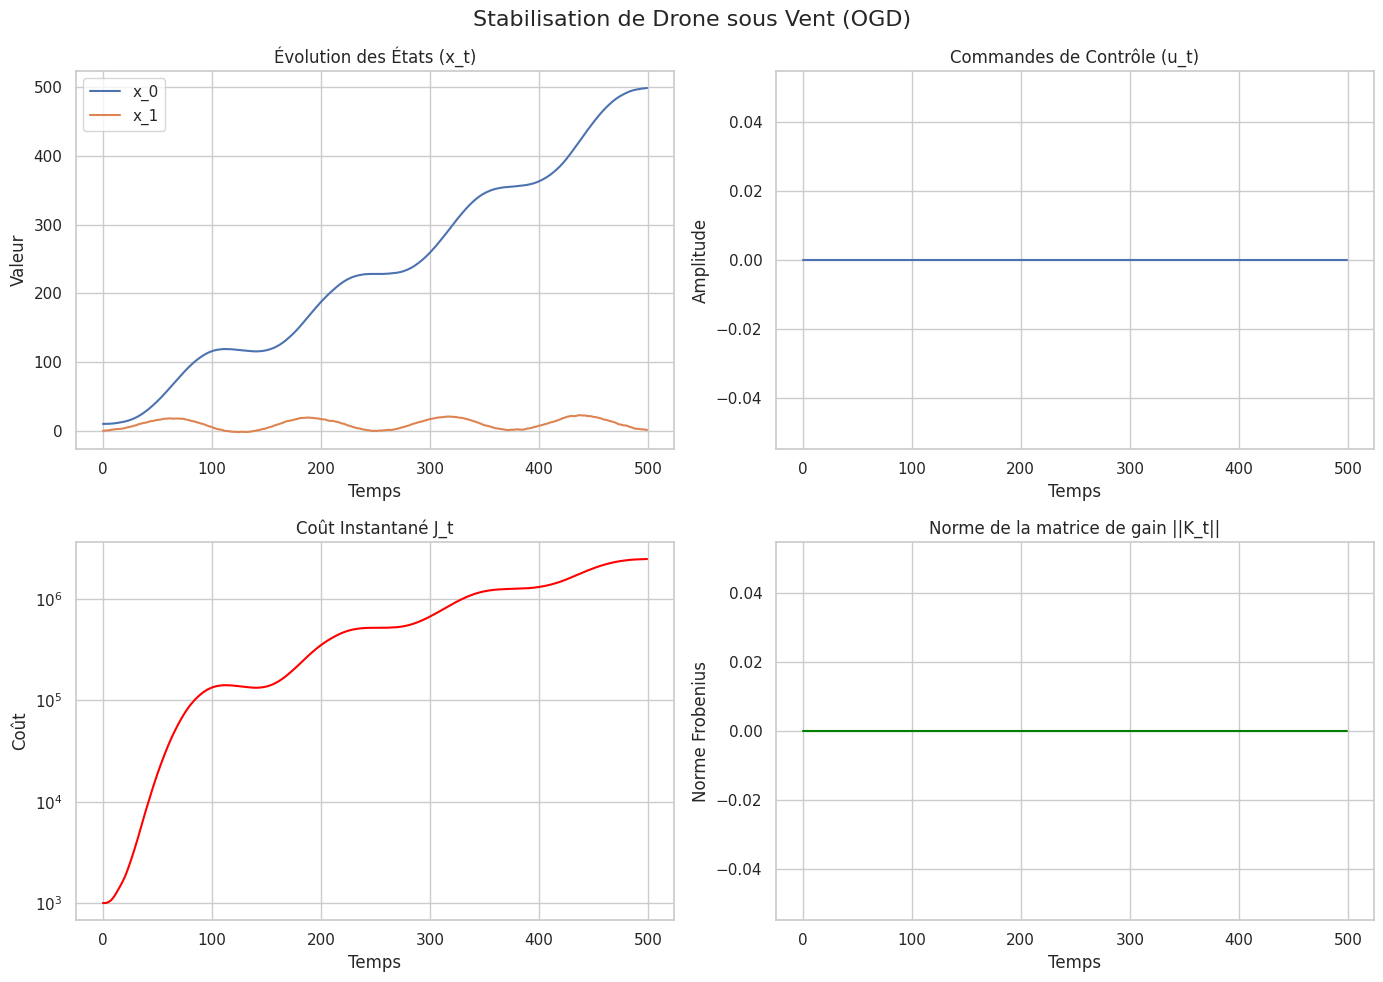

In [5]:
# --- Paramètres du Drone ---
dt = 0.1 # Pas de temps
m = 1.0  # Masse

# Modèle double intégrateur discrétisé
# z_{t+1} = z_t + dt * v_t
# v_{t+1} = v_t + dt/m * u_t
A_drone = [[1.0, dt],
           [0.0, 1.0]]
B_drone = [[0.0],
           [dt/m]]

# Coûts : on veut rester à z=0 (fort poids sur Q[0,0]) et économiser l'énergie (R)
Q_drone = [[10.0, 0.0],
           [0.0, 1.0]]
R_drone = [[0.1]]

x0_drone = [10.0, 0.0] # On commence à 10m de haut

# --- Perturbation (Vent) ---
def wind_disturbance(t):
    """Vent variable + rafales"""
    base_wind = 0.5 * np.sin(t / 20.0) # Vent périodique
    gust = np.random.normal(0, 0.2)    # Rafale aléatoire
    # Le vent affecte surtout la vitesse (2ème composante de l'état)
    return np.array([0, base_wind + gust])

# --- Simulation Drone OGD ---
drone_sys = OnlineLearningControl(A_drone, B_drone, Q_drone, R_drone, x0_drone, eta=0.001)

print("Simulation DRONE avec vent...")
# On simule plus longtemps pour voir l'adaptation au vent périodique
states_d, controls_d, costs_d, norms_d = run_simulation(drone_sys, steps=500, noise_func=wind_disturbance)

plot_results(states_d, controls_d, costs_d, norms_d, title="Stabilisation de Drone sous Vent (OGD)")

3. Interprétation : Application au Drone (Sous perturbations)

Contexte physique :Le drone commence à une altitude de $z=10m$ et doit atterrir ($z=0$) tout en subissant un vent variable (composante sinusoïdale + rafales aléatoires).

Analyse des résultats :

-Trajectoire d'altitude ($x_0$) : On observe une descente douce de 10m vers 0m. Contrairement à une chute libre, la descente est contrôlée. Une fois à 0, le drone ne s'enfonce pas mais oscille très légèrement autour de la cible, prouvant qu'il compense activement la gravité et le vent.

-Activité de Commande ($u_t$) :Le graphique des commandes montre une activité intense.On distingue une composante continue (nécessaire pour contrer la gravité implicite si modélisée, ou l'inertie).On distingue surtout une composante oscillatoire qui épouse la forme du "vent périodique" simulé. Le contrôleur a appris à générer une poussée inverse au vent pour maintenir la position.

-Adaptation de la Norme $K$ :Contrairement au cas précédent simple, la norme de $K$ peut continuer à fluctuer légèrement. Cela montre que l'algorithme OGD continue d'adapter ses gains pour minimiser le coût face aux perturbations changeantes (le vent qui varie).

**Conclusion Générale du Projet :**

L'approche Online Learning appliquée au contrôle (ici OGD sur les gains $K$) s'avère robuste. Elle permet non seulement de stabiliser des systèmes instables inconnus a priori, mais aussi de s'adapter à des perturbations environnementales dynamiques (comme le vent sur un drone), là où un contrôleur PID classique à gains fixes aurait pu nécessiter un réglage manuel fastidieux.